<p style="font-size:40px; text-align:center">
Computational Physics / Numerische Verfahren in der Physik; SoSe 2023
</p>
<p style="font-size:15px; text-align:center">
Lorenz von Smekal, Ralf-Arno Tripolt, Robin Kehr, Johannes Roth, Leon Sieke
<br>Justus-Liebig-Universität Gießen
</p>
<p style="text-align:center">
<img src="images/JLU_Giessen-Logo.png" width="400" style="background-color: white; padding: 20px; border-radius: 25px;"/>
</p>
<br>
<p style="font-size:30px; color: #3776ab; text-align:center"><b>
Projekt 3: Gezeitenreibung
<b></p>

<p style="font-size:25px; text-align:center">Bearbeitet von Finn Bietz, Florian Adamczyk und Finn Wagner</p>

## Beschreibung
- Bewegungsgleichungen
- Numerische Lösung von Anfangswertproblemen
- Animationen

### Einführung 

In diesem Projekt soll die Gezeitenreibung zwischen Erde und Mond studiert werden. In der folgenden Abbildung ist die Ausprägung zweier Flutberge (der Zenitflutberg ist dem Mond zugewandt, der Nadirflutberg ist dem Mond abgewandt)  skizziert. Diese entstehen durch die Anziehungskraft des Mondes und die Zentrifugalkraft, welche durch die Rotation der Erde um den Schwerpunkt des Erde-Mond Systems erzeugt wird. Da die intrinsische Rotationsperiode der Erde wesentlich kürzer ist als die Umlaufperiode des Mondes, dreht sich die Erde unter den Flutbergen hinweg.

Die dabei entstehende Reibungskraft zwischen den Flutbergen und der mit der Erde rotierenden Materie führt zu einer Verschiebung der Flutberge, so dass sie sich nicht, wie man ohne Reibung erwarten würde, auf der Verbindungslinie des Erd- und Mondmittelpunktes befinden, sondern in Richtung der intrinsischen Erdrotation verschoben sind. Der Zenitflutberg eilt also der Bewegung des Mondes voraus und beschleunigt durch seine Anziehungskraft die Bahnbewegung des Mondes, der sich infolge dessen auf einer größeren Umlaufbahn bewegt. Die intrinsische Rotation der Erde wiederum wird durch die Reibung mit den Flutbergen abgebremst. Diesen Effekt bezeichnet man als Gezeitenreibung. Er ist Gegenstand dieses Projektes. 

<p style="text-align:center">
<img src="images/skizze_gezeitenreibung.png"/>
</p>

Zur Vereinfachung betrachten wir die Gezeitenreibung nur für das Erde-Mond System  und vernachlässigen den Einfluss der Sonne. In der folgenden Zelle befinden sich verschiedene astronomische Größen des Erde-Mond Systems, welche während des Projektes benötigt werden. 

In [1]:
mErde = 5.9721986*10**24        # kg          : Masse der Erde
mOzean = 0.0014*10**24          # kg          : Masse der Ozeane auf der Erde
RErde = 6.3675*10**6            # kg          : Radius der Erde

mMond = 7.3459*10**22           # kg          : Masse des Mondes 
rMondBahn = 3.836*10**8         # m           : Bahnradius des Mondes, die Umlaufbahn des Mondes
                                #               um die Erde kann als Kreisbahn genähert werden
TMondBahn = 27.32166140*24*3600 # s           : Heutige Periodendauer der Mondumlaufbahn um die Erde

TErdRotation = 86164.100        # s           : Heutige Periodendauer der intrinsischen Erdrotation
tau = 0.0021                    # s/100a      : Zunahme der Tageslänge auf der Erde in 100 Jahren

G = 6.67430*10**(-11)           # m^3/(kg*s^2): Gravitationskonstante 

In diesem Projekt werden die folgenden Packages benötigt:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from scipy.constants import pi
from scipy.integrate import solve_ivp
from scipy.integrate._ivp.ivp import OdeResult # :) https://github.com/scipy/scipy/blob/main/scipy/integrate/_ivp/ivp.py

# !!!
Wenn ihr auch Lust habt damit rumzuspielen, man kann in Mathjax neue Commands erstellen ;)
$\newline$
Hier sind alle die ich bis jetzt gemacht habe (sieht man nicht).
$ \def\dv#1{ \frac{\mathrm{d}}{\mathrm{d} #1} } $
$ \def\Vec#1{ \overrightarrow{#1} } $ Aus dem Physics package.
$ \def\VecT#1#2{ \begin{pmatrix} #1 \\ #2 \end{pmatrix} } $ 2D Vector
$ \def\VecE#1{ \hat{e}_{#1} } $ Einheitsvektor
Hier ein schöner StackExchange [Post](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference/11638#11638) dazu 

$\providecommand{\e}[1]{\ensuremath{\cdot 10^{#1}}}$ mit \e-9 kann man normale Scientific notation machen
$\providecommand{\fehlt}{\textcolor{red}{\emph{Fehlt!\dots}}}$ benutze ich gerne in meinen LateX Dokumenten wenn noch was gemacht werden soll

In [3]:
# Beautiful plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"

### Leitfragen

#### Zweikörperproblem

- Programmieren Sie eine Funktion, die an die _SciPy_-Funktion `solve_ivp()` übergeben werden kann, um die gekoppelten Bewegungsgleichungen des Erde-Mond Systems ohne Flutberge numerisch für gegebene Anfangsbedingungen zu lösen. Dabei sollte die Masse $m_i$ jedes Körpers an die Funktion übergeben werden können.
    - Beschränken Sie das Problem auf die $x$-$y$-Ebene und behandeln Sie die beiden Körper als Punktmassen, die intrinsische Rotation der Erde soll also zunächst vernachlässigt werden.

Es handelt sich hier um das klassiche Zweikörperproblem, dass zuerst von Johannes Kepler angegeben und zuerst analytisch von Isaac Newton gelöst wurde.
$\newline$
Da hier zwei Körper eine Rolle spielen stellen wir zwei DGL auf:
\begin{align}
    m_1 \Vec{\ddot{z_1}} &= \Vec{F_{1,2}} \\
    m_2 \Vec{\ddot{z_2}} &= \Vec{F_{2,1}}
\end{align}
$\vec{F_{2,1}}$ steht hier für die Kraft, die die beiden Körper anzieht.
Hier handelt es sich natürlich um die Schwerkraft
\begin{gather}
    \Vec F_1 = G \frac{m_1 \cdot m_2}{r^2} \Vec e_{12} \\
    \mathrm{mit} \ r := \left| \Vec{z_2} - \Vec{z_1} \right|
\end{gather}
Zusätzlich gilt nach dem 3.ten Newtonschen Gesetz
\begin{equation}
    \Vec{F_{1,2}} = -\Vec{F_{2,1}}
\end{equation}
Wir setzen das Gravitationsgesetz nun in unsere DGL's ein und erhalten
\begin{align}
    \ddot{z_1} &= \frac{G \cdot m_2}{{\left( \left| \Vec{z_2} - \Vec{z_1} \right| \right) }^3} \cdot \left( \Vec{z_2} - \Vec{z_1} \right) \\
    \ddot{z_2} &= \frac{G \cdot m_1}{{\left( \left| \Vec{z_2} - \Vec{z_1} \right| \right) }^3} \cdot \left( \Vec{z_1} - \Vec{z_2} \right)
\end{align}
Wir erhalten also vier Gleichungen
\begin{align}
    \ddot{x_1} &= \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_2 - x_1 \right) \\
    \ddot{y_1} &= \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( y_2 - y_1 \right) \\
    \ddot{x_2} &= \frac{G \cdot m_1}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_1 - x_2 \right) \\
    \ddot{y_2} &= \frac{G \cdot m_1}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( y_2 - y_1 \right) \\
\end{align}

Die Methode `solve_ivp()` kann keine Differentialgleichungen $n$-ter Ordnung lösen.
Wir formen deshalb unser Problem in ein DGL-System erster Ordnung um.
$\newline$
Dazu führen wir eine neue Variable $v$ und $a$ ein.
\begin{gather}
    \dv{t} x_1(t) = v_1(t) \\
    \dv{t} v_1(t) = \frac{G \cdot m_2}{{\left( \left| \Vec{x_2} - \Vec{x_1} \right| \right) }^3} \cdot \left( x_2 - x_1 \right) \\
\end{gather}
Dieses verfahren wenden wir äquivalent für die anderen drei Gleichungen an.

In [4]:
# https://stackoverflow.com/questions/59634279/solve-ivp-error-required-step-size-is-less-than-spacing-between-numbers

# The function of derivatives / differential equations passed to solve_ivp
def eq_motion_2body(t, state, mass):
    x_1, v_x_1, x_2, v_x_2, y_1, v_y_1, y_2, v_y_2 = state # Unpack the state vector
    dist_em = ((x_2 - x_1)**2 + (y_2 - y_1)**2 )**0.5 # Distance between the two bodys
    # Calculate the derivatives of the state vector
    dx1_dt = v_x_1
    dv_x1_dt = G * mass[1] / (dist_em**3) * (x_2 - x_1)
    dx2_dt = v_x_2
    dv_x2_dt = G * mass[0] / (dist_em**3) * (x_1 - x_2)
    dy1_dt = v_y_1
    dv_y1_dt = G * mass[1] / (dist_em**3) * (y_2 - y_1)
    dy2_dt = v_y_2
    dv_y2_dt = G * mass[0] / (dist_em**3) * (y_1 - y_2)

    return np.array([dx1_dt, dv_x1_dt, dx2_dt, dv_x2_dt, dy1_dt, dv_y1_dt, dy2_dt, dv_y2_dt])

def two_body_problem(mass: list, x: list, y: list, v_x: list, v_y: list, t_max: float, t_start=0):
    # mass: contains the masses of the bodys
    # x: contains the strarting x coordinates of the bodys
    # y: contains the strarting y coordinates of the bodys
    # v_x: contains the strarting x-velocities of the bodys
    # v_y: contains the strarting y-velocities of the bodys

    # We need to add tolearances because the values are very large
    # dense_output makes the function compute a continous solution in the given time interval
    solution = solve_ivp(eq_motion_2body, [t_start, t_max], [x[0], v_x[0], x[1], v_x[1], y[0], v_y[0], y[1], v_y[1]], args=(mass,), dense_output=True, atol=1e-4*rMondBahn, max_step=TMondBahn/1000)
    # We read the solution from the solution object
    t = solution.t
    x1, v_x1, x2, v_x2, y1, v_y1, y2, v_y2 = solution.y
    return [t, x1, x2, y1, y2]

- Erstellen Sie verschiedene Plots, die die Zeitentwicklung am besten illustrieren, z.B. parametrische Plots der Bahnen beider Körper oder geeignete Phasenraumplots. 
    - Wählen Sie dabei die Anfangsbedingungen so, dass der Schwerpunkt des Zweiteilchensystems im Ursprung ruht.

Um das System beschreiben zu können müssen wir zunächst sinnvole Anfangsbedingungen wählen. $ \newline $
Wir wählen als Anfangsbedingungen die real herschenden Bedingungen

In [5]:
# Calculate the barycenter of two bodies (The point around which both bodies orbit)
def baryzentrum(m1, m2, r):
    # Returns the distance of the barycenter from the body with mass m1
    return r*m2/(m1+m2)

abstand_baryzentrum_erde = baryzentrum(mErde, mMond, rMondBahn)
vErde = 2*pi*abstand_baryzentrum_erde/TMondBahn
vMond = 2*pi*(rMondBahn-abstand_baryzentrum_erde)/TMondBahn

def iv_stable_orbit():
    # Initial conditions for the Earth-Moon system in a stable orbit
    mass = [mErde, mMond]
    # We want the center of mass to be at the origin
    x = [-abstand_baryzentrum_erde, rMondBahn-abstand_baryzentrum_erde]
    y = [0, 0]
    v_x = [0, 0]
    v_y = [-vErde, vMond] # The moon starts in positive, the earth in negative y-direction
    return [mass, x, y, v_x, v_y]

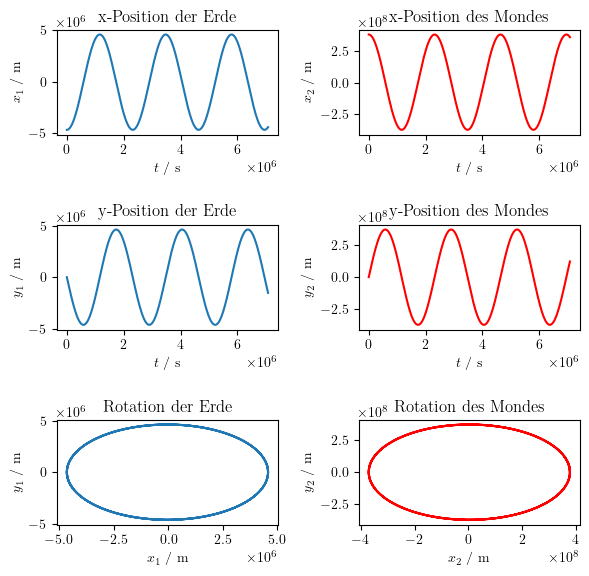

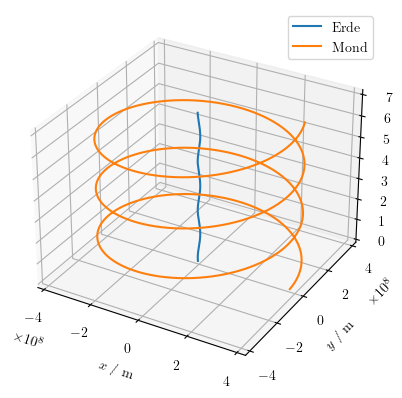

In [6]:
%matplotlib inline
# Plot the solution of the two body problem as a phase space diagram
t, x1, x2, y1, y2 = two_body_problem(*iv_stable_orbit(), 3*TMondBahn)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 6))
fig.set_label("Phasenraumdiagramme des Erde-Mond-Systems")

axes[0, 0].plot(t, x1)
axes[0, 0].set_xlabel("$t$ / s")
axes[0, 0].set_ylabel("$x_1$ / m")
axes[0, 0].set_title("x-Position der Erde")

axes[0, 1].plot(t, x2, color="red")
axes[0, 1].set_xlabel("$t$ / s")
axes[0, 1].set_ylabel("$x_2$ / m")
axes[0, 1].set_title("x-Position des Mondes")

axes[1, 0].plot(t, y1)
axes[1, 0].set_xlabel("$t$ / s")
axes[1, 0].set_ylabel("$y_1$ / m")
axes[1, 0].set_title("y-Position der Erde")

axes[1, 1].plot(t, y2, color="red")
axes[1, 1].set_xlabel("$t$ / s")
axes[1, 1].set_ylabel("$y_2$ / m")
axes[1, 1].set_title("y-Position des Mondes")

axes[2, 0].plot(x1, y1)
axes[2, 0].set_xlabel("$x_1$ / m")
axes[2, 0].set_ylabel("$y_1$ / m")
axes[2, 0].set_title("Rotation der Erde")

axes[2, 1].plot(x2, y2, color="red")
axes[2, 1].set_xlabel("$x_2$ / m")
axes[2, 1].set_ylabel("$y_2$ / m")
axes[2, 1].set_title("Rotation des Mondes")

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()
plt.close()

# Plot a 3d phase space diagram
fig = plt.figure()
fig.set_label("3D-Phasenraumdiagramm des Erde-Mond-Systems")
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, y1, t, label="Erde")
ax.plot(x2, y2, t, label="Mond")
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.legend()
plt.show()
plt.close()

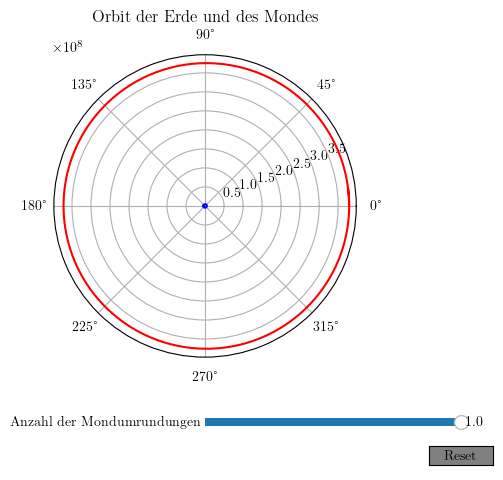

In [7]:
# We also want to plot the solution in polar coordinates with sliders using ipympl
# %matplotlib widget
from matplotlib.widgets import Slider, Button

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
fig.set_label("Polarplot des Systems Erde-Mond")
plt.subplots_adjust(left=0, bottom=0.25)

# Calculate the solution for the initial conditions given above
solution = two_body_problem(*iv_stable_orbit(), TMondBahn)
t, x_1_values, x_2_values, y_1_values, y_2_values = solution

# TODO Move to helper functions
# Define the functions that convert cartesian coordinates to polar coordinates
r = lambda x, y: np.sqrt(x**2 + y**2)
theta = lambda x, y: np.arctan2(y, x)

# We need to plot the solution
ax.plot(theta(x_1_values, y_1_values), r(x_1_values, y_1_values), color='blue', label='Erde')
ax.plot(theta(x_2_values, y_2_values), r(x_2_values, y_2_values), color='red', label='Mond')
ax.set_title("Orbit der Erde und des Mondes")

# We need to define the axes for the sliders
axMondUmdrehungen = plt.axes([0.45, 0.1, 0.4, 0.03])

# We need to define the sliders
sMondUmdrehungen = Slider(ax=axMondUmdrehungen, label='Anzahl der Mondumrundungen', valmin=0.1, valmax=1, valinit=1)

# We need to define a function that updates the plot when the sliders are moved
def update(val):
    nMondUmdrehungen = sMondUmdrehungen.val

    # We need to calculate the initial conditions again because they depend on the sliders
    solution = two_body_problem(*iv_stable_orbit(), nMondUmdrehungen*TMondBahn)
    t, x_1_values, x_2_values, y_1_values, y_2_values = solution
    ax.clear()
    ax.plot(theta(x_1_values, y_1_values), r(x_1_values, y_1_values), color='blue', label='Erde')
    ax.plot(theta(x_2_values, y_2_values), r(x_2_values, y_2_values), color='red', label='Mond')
    ax.set_title("Orbit der Erde und des Mondes")
    fig.canvas.draw_idle()

# We need to connect the sliders to the update function
sMondUmdrehungen.on_changed(update)

# We need to define a reset button
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color="grey", hovercolor='0.975')

# We need to define a function that resets the sliders
def reset(event):
    sMondUmdrehungen.reset()
button.on_clicked(reset)

plt.show()

- Betrachten Sie die zeitliche Entwicklung des Schwerpunktes. Wie sollte seine Bahn in einem abgeschlossenem System verlaufen und ist dies tatsächlich der Fall? 

Der Schwerpunkt sollte sich in einem abgeschlossenen System nicht bewegen.
Gegen die Zeit aufgetragen, sollten seine x-, und y-Komponente also eine Konstante bei Null (wegen der Anfangsbedingungen, Schwerpunkt im Ursprung) sein.
Wie hier im Plot zu sehen ist, ist dies bei unseren Berechnungen nicht der Fall.
Die hier bestimmten Werte liegen aber im Bereich von $10^{-5}$ Metern, sind also um
ein mehrere Größenordnungen kleiner als unsere betrachteten Abstände zwischen Erde und Mond.
Diese Fehler entstehen hier durch die numerische Berechnung des Problems.
Sie entstehen hier entweder durch das numerische Lösen der DGL oder durch die
Ungenauigkeit des float-Datentypen und der angegebenen Anfangswerte.

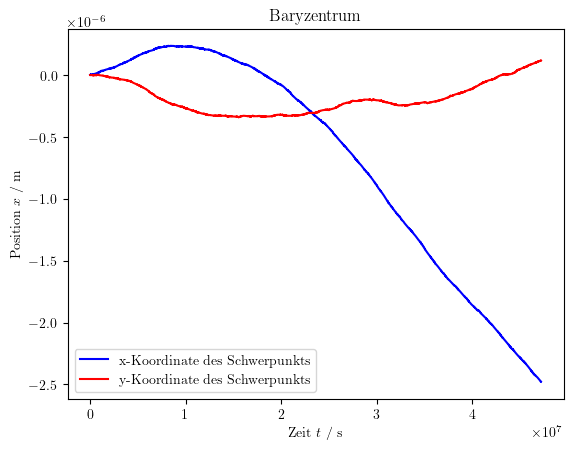

In [8]:
solution = two_body_problem(*iv_stable_orbit(), 20*TMondBahn)
t, x_1_values, x_2_values, y_1_values, y_2_values = solution

# Define a function which calculates the location of the center of mass
def center_of_mass(m1, m2, x1, y_1, x2, y_2):
    x = (m1*x1+m2*x2)/(m1+m2)
    y = (m1*y_1+m2*y_2)/(m1+m2)
    return x, y

# Plot the change of the center of mass over time
%matplotlib inline
fig, ax = plt.subplots()
fig.set_label("Bewegung des Baryzentrum des Erde-Mond-Systems")
ax.plot(t, center_of_mass(mErde, mMond, x_1_values, y_1_values, x_2_values, y_2_values)[0], color='blue', label='x-Koordinate des Schwerpunkts')
ax.plot(t, center_of_mass(mErde, mMond, x_1_values, y_1_values, x_2_values, y_2_values)[1], color='red', label='y-Koordinate des Schwerpunkts')
ax.set_xlabel('Zeit $t$ / s')
ax.set_ylabel('Position $x$ / m')
ax.set_title('Baryzentrum')
ax.legend()
plt.show()
plt.close()

- Implementieren Sie das explizite Euler-Verfahren und das explizite Runge-Kutta-Verfahren 4. Ordnung aus der Vorlesung. 

Das explizite Euler-Verfahren, auch eulersches Polygonzugverfahren, wurde von Leonhard Euler 1768 veröffentlicht.
$ \newline $
Gegeben sei ein Anfangswertproblem der Form:
\begin{equation}
    \dv{t} y(t) = f(t, y(t)) \quad \mathrm{mit} \quad y(t_0) = y_0
\end{equation}

TODO: Herleitung der Gleichung

Die Differentialgleichungen unseres Problems sind gewöhnlich.
Wir wählen eine Diskretisierungs-Schrittweite $h > 0$
und betrachten diskrete Zeitpunkte $t_k = t_0 + k \cdot h$ mit $k \in \mathbb{N}_0$.
$ \newline $
Wir berechnen die Werte $y_k$ der Lösung $y(t)$ an den Zeitpunkten $t_k$.
Diese sind gegben durch
\begin{equation}
    y_{k+1} = y_k + h \cdot f(t_k, y_k) \quad \mathrm{mit} \quad k \in \mathbb{N}_0
\end{equation}

$ \newline $
[Quelle](https://de.wikipedia.org/wiki/Explizites_Euler-Verfahren) und Skript ?

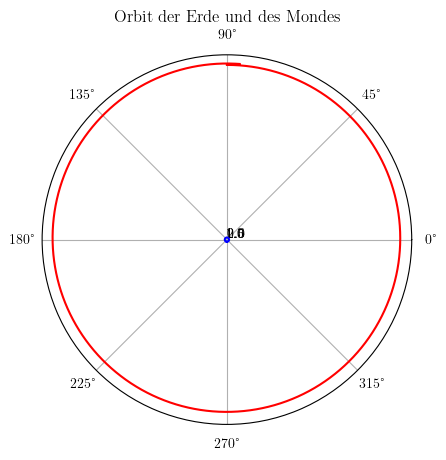

In [9]:
# Implementation of the explicit Euler method
# The method takes the function fun (same convention as solve_ivp), the time interval [t_0, t_end], the initial conditions y_0, the step size h

def explicit_euler(fun, t_span, y_0, steps, args=()):
    # Calculate h, the time step, from the number of steps
    h = (t_span[1]-t_span[0])/steps
    # Create an array of the time steps
    t = np.linspace(t_span[0], t_span[1], steps+1, dtype=np.float64)
    # Create an array for the solution
    y = np.zeros((steps+1, len(y_0)), dtype=np.float64)
    # Set the initial conditions
    y[0] = y_0
    # Iterate over the time steps
    for i in range(steps):
        # Calculate the next step using the explicit Euler method
        y[i+1] = y[i] + h*fun(t[i], y[i], *args)
    # Return OdeResult from solve_ivp ;)
    return OdeResult(t=t, y=y.T)
    
def two_body_problem_euler(mass: list, x: list, y: list, v_x: list, v_y: list, t_max: float, h, t_start=0):
    # Same defintions as above
    solution = explicit_euler(eq_motion_2body, [t_start, t_max], [x[0], v_x[0], x[1], v_x[1], y[0], v_y[0], y[1], v_y[1]], h, args=(mass,))
    t = solution.t
    x1, v_x1, x2, v_x2, y1, v_y1, y2, v_y2 = solution.y
    return [t, x1, x2, y1, y2]
    

solution = two_body_problem_euler(*iv_stable_orbit(), TMondBahn, 10000)

# Plot the orbits
t, x_1_values, x_2_values, y_1_values, y_2_values = solution

# To plot the solution in polar coordinates we need to convert the cartesian coordinates to polar coordinates
r = lambda x, y: np.sqrt(x**2 + y**2)
theta = lambda x, y: np.arctan2(x, y)

# Polar plot
%matplotlib inline
fig1, ax1 = plt.subplots(subplot_kw={'projection': 'polar'})
ax1.plot(theta(x_1_values, y_1_values), r(x_1_values, y_1_values), color='blue', label='Erde')
ax1.plot(theta(x_2_values, y_2_values), r(x_2_values, y_2_values), color='red', label='Mond')
ax1.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax1.set_title("Orbit der Erde und des Mondes")
plt.show()
plt.close()

Das Runge-Kutta 4.Ordnung oder auch das "Klassisches Runge-Kutta-Verfahren" (RK4) ist nach Carl Runge und Martin Kutta benannt.
$ \newline $
Gegeben sei ein Anfangswertproblem der Form:
\begin{equation}
    \dv{t} y(t) = f(t, y(t)) \quad \mathrm{mit} \quad y(t_0) = y_0, \quad y: \mathbb{R} \rightarrow \mathbb{R}^n
\end{equation}


$ \newline $
[Quelle](https://de.wikipedia.org/wiki/Klassisches_Runge-Kutta-Verfahren) und Skript ?

- Lösen Sie mit Ihren Implementierungen die Bewegungsgleichungen des Erde-Mond-Systems erneut. Vergleichen Sie die Ergebnisse untereinander und mit dem Ergebnis der obigen Funktion. Vergleichen Sie alle Ergebnisse auch mit der exakten Lösung des Zweikörperproblems.

#### Vierkörperproblem mit Randbedingungen

- Erweitern Sie die obige Funktion um die beiden Flutberge, die sich auf der Erdoberfläche befinden.
    Dazu werden die beiden Flutberge als Punktmassen genähert, dessen Abstand zur Erde zu jeder Zeit dem Erdradius entspricht. Aufgrund dieser Zwangsbedingungen gestaltet sich die Herleitung der Bewegungsgleichungen als kompliziert. 
        
    Sei $\Vec{F_{ba}}$ die Gravitationskraft, die ein Körper $b$ auf einen Körper $a$ ausübt. Die gegenseitige Gravitationskraft der beiden Flutberge ist sehr gering und wird daher im Folgenden vernachlässigt, d.h. $\vec F_{21}$=$\vec F_{12}=0$. 
        
    Die radiale Kompenente der Kraft auf die beiden Flutberge muss so festgesetzt werden, dass ihr jeweiliger Abstand zur Erde gleich bleibt, also zu jeder Zeit dem Erdradius entspricht. Dies wird mit dem Einführen von radial gerichteten Zwangskräften bewerkstelligt. Da die Gravitationskraft von der Erde auf die Flutberge ebenfalls radial gerichtet ist, kann diese implizit in die Definition der Zwangskräfte mit eingebaut werden, $\vec F_{\mathrm{Z}1}$ und $\vec F_{\mathrm{Z}2}$ stellen also die Summe der jeweiligen Zwangskraft und der Gravitationskraft der Erde auf Flutberg 1 bzw. Flutberg 2 dar. Auf die Erde wirken diese Kräfte mit entgegengesetztem Vorzeichen. 
        
    Damit ergibt sich für die Gesamtkräfte $\vec F_\mathrm{E}$, $\vec F_\mathrm{M}$, $\vec F_1$, $\vec F_2$ auf Erde, Mond, Flutberg 1 bzw. Flutberg 2 folgendes Gleichungssystem:
    
$\newline$
\begin{align*}
    \vec F_\mathrm{E} &= \vec F_\mathrm{ME} - \vec F_{\mathrm{Z}1} - \vec F_{\mathrm{Z}2} \\
    \vec F_\mathrm{M} &= \vec F_\mathrm{EM} + \vec F_{1\mathrm{M}} + \vec F_{2\mathrm{M}} \\
    \vec F_1 &=  \vec F_{\mathrm{M}1} + \vec F_{\mathrm{Z}1} \\
    \vec F_2 &= \vec F_{\mathrm{M}2} + \vec F_{\mathrm{Z}2}      
\end{align*}

Die Koordinaten des $i$-ten Flutbergs lassen sich am elegantesten in Polarkoordinaten relativ zu den Erdkoordinaten $\vec r_\mathrm{E}$ angeben:
$\newline$
\begin{equation*}
    \vec r_i = \vec r_\mathrm{E} + R_\mathrm{E}\,\vec e_{r,i}\,,
\end{equation*}

wobei $\vec e_{r,i}$ den radialen Einheitsvektor in Bezug auf den $i$-ten Flutberg darstellt. Die Kraft auf den $i$-ten Flutberg lässt sich nun in einen radialen Anteil und einen Winkelanteil aufteilen:
$\newline$
\begin{align*}
    \vec F_i &= (\vec F_{\mathrm{M}i})_{\varphi,i} \vec e_{\varphi,i} + (\vec F_{\mathrm{M}i})_{r,i} \vec e_{r,i} + F_{\mathrm{Z}i} \vec e_{r,i} \\
    &= (\vec F_{\mathrm{M}i})_{\varphi,i} \vec e_{\varphi,i} + ((\vec F_{\mathrm{M}i})_{r,i} + F_{\mathrm{Z}i})\, \vec e_{r,i}\,. 
\end{align*}

Hierbei stellt $\vec e_{\varphi,i}$ den Einheitsvektor in $\varphi_i$-Richtung und $\varphi_i$ den Winkel des $i$-ten Flutbergs relativ zu den Erdkoordinaten dar. Die Beschleunigung des $i$-ten Flutberg in Richtung Erde muss der Zentripetalbeschleunigung für stabile Kreisbahnen abzüglich der Beschleunigung der Erde in radiale Richtung betragen, damit die Zwangsbedingung (ZB) erfüllt ist, d.h.
$\newline$
\begin{equation*}
    (\vec F_{\mathrm{M}i})_{r,i} + F_{\mathrm{Z}i} \stackrel{\mathrm{ZB}}{=} -m_i \left( R_\mathrm{E} \dot{\varphi}_i^2 - (\ddot{\vec r_\mathrm{E}})_{r,i} \right)\,,
\end{equation*}

wobei $m_i$ die Masse des $i$-ten Flutbergs ist. 
    
Dies lässt sich mit einer Analogie zum Fadenpendel verstehen, wobei die Masse am Pendel einem Flutberg bzw. der Aufhängepunkt der Erde entspricht. Jedoch muss hier zusätzlich berücksichtigt werden, dass die Erde im Gegensatz zum Aufhängepunkt beim Fadenpendel zusätzlich beschleunigt werden kann, weshalb die Beschleunigung der Erde in radiale Richtung von der Zentripetalbeschleunigung subtrahiert werden muss. So wird zum Beispiel die Zwangsbedingung bereits eingehalten, wenn die Erde in Richtung eines Flutbergs mit dem Betrag der Zentripetalbeschleunigung beschleunigt wird und auf den Flutberg keine radiale Beschleunigung wirkt. 
 
Aus den Kräftgleichungen lassen sich nun die benötigten Bewegungsgleichungen ablesen. Beachten Sie, dass die Gleichungen für die Flutberge jeweils nur eine Bewegungsgleichung bezüglich des jeweiligen Winkels liefern, während die Bewegungsgleichung bezüglich der radialen Koordinate aufgrund der Zwangsbedingung redundant ist. Im Gegensatz zu dieser Herleitung mit Newtonscher Mechanik lassen sich die Bewegungsgleichungen wesentlich leichter mit dem Lagrangeformalismus, welcher die Zwangsbedingungen auf eine natürliche Art implementiert, herleiten.
    
Mit den Bewegungsgleichungen in dieser Form lässt sich allerdings noch keine geeignete Funktion definieren, die zwecks Lösen des Systems an `solve_ivp()` übergeben werden kann, da die Bewegungsgleichungen für Erde und Flutberge mehrere zweite zeitliche Ableitungen der Koordinaten beinhalten. Daher muss das Gleichungssystem zunächst nach den verschiedenen Beschleunigungen umgestellt werden. Dafür eignet sich die _SymPy_-Funktion `linsolve()`. Anschließend können die damit erhaltenen symbolischen Ausdrücke in numerische Funktionen umgewandelt werden. Verwenden Sie hierzu unbedingt `lambdify()`, da `subs()` sehr viel Rechenzeit in Anpruch nimmt.
$\newline$    
- Betrachten Sie die zeitliche Entwicklung des Vierteilchensystems.
    - Teilen Sie dabei zunächst die Masse der Ozeane auf die beiden Flutberge gleichmäßig auf und lassen Sie die beiden Flutberge auf der Verbindungslinie zwischen Erde und Mond mit der Umlaufperiodendauer des Mondes starten. Passen Sie die Anfangsbedingungen so an, dass der Schwerpunkt wieder im Ursprung ruht.

## Finns Ansatz mit Lagrnange 2.Art

In [184]:
def diff_eqs_2_body_problem():
    t = sympy.symbols('t', real=True, positive=True) # Time variable for all functions
    # m_E, m_M, m_1, m_2, r_earth = sympy.symbols('m_E m_M m_1 m_2, R_E', real=True, positive=True)
    m_E, m_M, m_1, m_2, r_earth = (mErde, mMond, mOzean/2, mOzean/2, RErde)
    # Define the masses of the bodies
    masses = [m_E, m_M, m_E, m_M]

    # Calculate using hamiltonian mechanics and cartesian coordinates
    x_E, x_M, y_E, y_M = sympy.symbols('x_E x_M y_E y_M', real=True, cls=sympy.Function)

    q_list = (x_E(t), x_M(t), y_E(t), y_M(t)) # Generalized coordinates
    p_list = (m_E*sympy.diff(x_E(t), t), m_M*sympy.diff(x_M(t), t), m_E*sympy.diff(y_E(t), t), m_M*sympy.diff(y_M(t), t)) # Generalized momenta

    # Position vector using coordinates
    r = sympy.Matrix([x_E(t), x_M(t), y_E(t), y_M(t)])
    r_dot = r.diff(t) # sympy.simplify(r_dot) Not necessary

    # Calculate the potential energy
    U = -G * m_E * m_M / (sympy.Matrix([x_E(t) - x_M(t), y_E(t) - y_M(t)]).norm())

    # Calculate the kinetic energy, square the velocity vector and sum over the masses
    T = 0 # Note: Just simplify or trigsimp don't do anything
    for i in range(len(masses)):
        T += masses[i] * r_dot[i]**2 / 2

    # print("Velocity vector:")
    # display(r_dot)
    # print("Potential energy:")
    # display(U)
    # print("Kinetic energy:")
    # display(T)
    return (t, r, r_dot, U, T, q_list, p_list, masses)

In [185]:
def diff_eqs_4_body_problem():
    t = sympy.symbols('t', real=True, positive=True) # Time variable for all functions
    # m_E, m_M, m_1, m_2, r_earth = sympy.symbols('m_E m_M m_1 m_2, R_E', real=True, positive=True)
    m_E, m_M, m_1, m_2, r_earth = (mErde, mMond, mOzean/2, mOzean/2, RErde)
    # Define the masses of the bodies
    masses = [m_E, m_M, m_E, m_M, m_1, m_2]

    # Calculate using hamiltonian mechanics and cartesian coordinates
    x_E, x_M, y_E, y_M, phi_1, phi_2 = sympy.symbols('x_E x_M y_E y_M phi_1 phi_2', real=True, cls=sympy.Function)

    q_list = (x_E(t), x_M(t), y_E(t), y_M(t), phi_1(t), phi_2(t)) # Generalized coordinates
    p_list = (m_E*sympy.diff(x_E(t), t), m_M*sympy.diff(x_M(t), t), m_E*sympy.diff(y_E(t), t), m_M*sympy.diff(y_M(t), t), m_E*r_earth**2 *sympy.diff(phi_1(t), t), m_E*r_earth**2*sympy.diff(phi_2(t), t)) # Generalized momenta

    # Position vector using coordinates
    r = sympy.Matrix([  x_E(t), x_M(t), y_E(t), y_M(t), 
                        x_E(t) + r_earth * sympy.cos(phi_1(t)), y_E(t) + r_earth * sympy.sin(phi_1(t)),
                        x_E(t) + r_earth * sympy.cos(phi_2(t)), y_E(t) + r_earth * sympy.sin(phi_2(t))])
    r_dot = r.diff(t) # sympy.simplify(r_dot) Not necessary

    # Calculate the potential energy
    U = - G * m_E * m_M / (sympy.Matrix([x_E(t) - x_M(t), y_E(t) - y_M(t)]).norm()) \
        - G * m_M * m_1 / (sympy.Matrix([x_M(t) - (x_E(t) + r_earth * sympy.cos(phi_1(t))), y_M(t) - (y_E(t) + r_earth * sympy.sin(phi_1(t)))]).norm()) \
        - G * m_M * m_2 / (sympy.Matrix([x_M(t) - (x_E(t) + r_earth * sympy.cos(phi_2(t))), y_M(t) - (y_E(t) + r_earth * sympy.sin(phi_2(t)))]).norm())

    # Calculate the kinetic energy, square the velocity vector and sum over the masses
    T = 0 # Note: Just simplify or trigsimp don't do anything
    for i in range(len(masses)):
        T += masses[i] * r_dot[i]**2 / 2

    # print("Velocity vector:")
    # display(r_dot)
    # print("Potential energy:")
    # display(U)
    # print("Kinetic energy:")
    # display(T)
    return (t, r, r_dot, U, T, q_list, p_list, masses)


In [226]:
t, r, r_dot, U, T, q_list, p_list, masses = diff_eqs_2_body_problem()

def lagrange_eqs():
    L = T - U # Calculate the Lagrangian

    # Calculate the Euler-Lagrange equations
    eqs = [(sympy.diff(L.diff(q.diff(t)), t) - L.diff(q)) for q in q_list]

    diff_eqs = []
    for eq, q in zip(eqs, q_list):
        a = sympy.solve(sympy.Eq(0, eq), q.diff(t, t))
        diff_eqs.append(q.diff(t))
        diff_eqs.append(a[0])

    # print("Lagrangian:")
    # display(L) # Here simplify or trigsimp also don't do anything
    # print("Euler-Lagrange equations:")
    # for eq in diff_eqs:
    #     print('Equation:')
    #     display(eq)
    return diff_eqs

def hamilton_eqs():
    H = T + U # Hamiltonian # H = sympy.Matrix(p_list).dot(v) - U
    diff_eqs = []
    # Calculate the Hamilton equations
    for q, p, m in zip(q_list, p_list, masses):
        # We need to substitute p to be allowed to differentiate it
        p_const = sympy.symbols('p_const')
        H_sub = H.subs(q.diff(t), p_const/m) # Sub in the constant
        derivative = H_sub.diff(p_const) # Differentiate
        derivative_resubed = derivative.subs(p_const, p) # Sub back in the variable
        diff_eqs.append(derivative_resubed)

        diff_eqs.append(-H.diff(q) / m)

        # display(p)
        # display(H)
        # display(H_sub)
        # display(derivative)
        # display(derivative_resubed)

    print("Hamiltonian:")
    display(H)
    print("Hamilton equations:")
    for eq in diff_eqs:
        print('Equation:')
        display(eq)

    return diff_eqs

def diff_eqs_lambdify(diff_eqs):
    # Substitute the constants
    # diff_eqs = [eq.subs([(m_E, mErde), (m_M, mMond), (m_1, mOzean/2), (m_2, mOzean/2), (r_earth, RErde)]) for eq in diff_eqs]
    # Create variables for the time and the generalized coordinates
    q_consts = sympy.symbols(' '.join(str(q) for q in q_list))
    q_dot_consts = sympy.symbols(' '.join(str(q) + '/dt' for q in q_list))
    # The variable order is pairs of (q, q_dot)
    variable_order = []
    for q, q_dot in zip(q_consts, q_dot_consts):
        variable_order.append(q)
        variable_order.append(q_dot)

    lambdified_diff_eqs = []
    for f in diff_eqs:
        # Using sympys subs function we substitue the generalized coordinates with the variables
        f_subs = f.subs([(q.diff(t), q_dot_const) for q, q_dot_const in zip(q_list, q_dot_consts)]) # We have to substitute the derivatives first!!!
        f_subs = f_subs.subs([(q, q_const) for q, q_const in zip(q_list, q_consts)])
        # Convert the equations to a function with lambdify
        f_lambdified = sympy.lambdify([t, variable_order], f_subs, modules='numpy')
        lambdified_diff_eqs.append(f_lambdified)

        # display(f)
        # display(f_subs)
        # print(variable_order)
        # print(f_lambdified(1, [1, 2, 3, 4, 5, 6, 7, 8]))

    return lambda t, y: np.array([f(t, y) for f in lambdified_diff_eqs])

Hamiltonian:


2.9860993e+24*Derivative(x_E(t), t)**2 + 3.67295e+22*Derivative(x_M(t), t)**2 + 2.9860993e+24*Derivative(y_E(t), t)**2 + 3.67295e+22*Derivative(y_M(t), t)**2 - 2.92809374597477e+37/sqrt((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)

Hamilton equations:
Equation:


1.0*Derivative(x_E(t), t)

Equation:


4902874037000.0*(-x_E(t) + x_M(t))/((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)

Equation:


1.0*Derivative(x_M(t), t)

Equation:


398602451159800.0*(x_E(t) - x_M(t))/((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)

Equation:


1.0*Derivative(y_E(t), t)

Equation:


4902874037000.0*(-y_E(t) + y_M(t))/((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)

Equation:


1.0*Derivative(y_M(t), t)

Equation:


398602451159800.0*(y_E(t) - y_M(t))/((x_E(t) - x_M(t))**2 + (y_E(t) - y_M(t))**2)**(3/2)

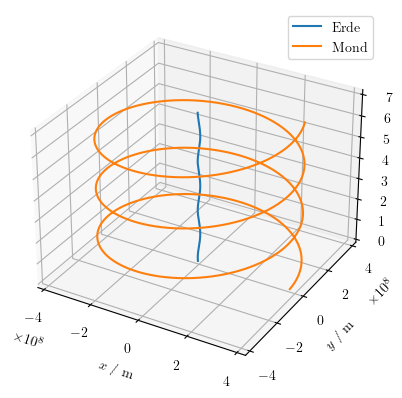

In [227]:
# Same as the solution above just with lagrange
eq_motion_2body = diff_eqs_lambdify(hamilton_eqs())

# Solve using scipy.integrate.solve_ivp
def four_body_problem(mass: list, x: list, y: list, v_x: list, v_y: list, t_max: float, t_start=0):
    # mass: contains the masses of the bodies
    # r_E0, phi_E0: initial position of the earth
    # r_M0, phi_M0: initial position of the moon
    # phi_10, phi_20: initial position of the flood masses

    # TODO lambdify with mass args=(mass,)
    solution = solve_ivp(eq_motion_2body, [t_start, t_max], [x[0], v_x[0], x[1], v_x[1], y[0], v_y[0], y[1], v_y[1]], dense_output=True, atol=1e-4*rMondBahn, max_step=TMondBahn/1000)
    return solution

# Plot the solution in polar coordinates
solution = four_body_problem(*iv_stable_orbit(), 3*TMondBahn)

# Plot a 3d phase space diagram
t = solution.t
x1, v_x1, x2, v_x2, y1, v_y1, y2, v_y2 = solution.y
fig = plt.figure()
fig.set_label("3D-Phasenraumdiagramm des Erde-Mond-Systems")
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, y1, t, label="Erde")
ax.plot(x2, y2, t, label="Mond")
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.legend()
plt.show()
plt.close()

In [ ]:
eq_motion_4body = diff_eqs_lambdify(lagrange_eqs())

# Define the initial values
def iv_stable_orbit_4body_tide():
    mass, x, y, v_x, v_y = iv_stable_orbit()

    return iv_stable_orbit()

# Solve using scipy.integrate.solve_ivp
def four_body_problem(mass: list, x: list, y: list, v_x: list, v_y: list, t_max: float, t_start=0):
    # mass: contains the masses of the bodies
    # r_E0, phi_E0: initial position of the earth
    # r_M0, phi_M0: initial position of the moon
    # phi_10, phi_20: initial position of the flood masses

    # TODO lambdify with mass args=(mass,)
    solution = solve_ivp(eq_motion_4body, [t_start, t_max], [x[0], v_x[0], x[1], v_x[1], y[0], v_y[0], y[1], v_y[1]], dense_output=True, atol=1e-4*rMondBahn, max_step=TMondBahn/1000)
    return solution

# Plot the solution in polar coordinates
solution = four_body_problem(*iv_stable_orbit_4body_tide(), 3*TMondBahn)
# Set option to print whole numpy arrays
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(solution.y)

# Plot a 3d phase space diagram
t = solution.t
x1, v_x1, x2, v_x2, y1, v_y1, y2, v_y2 = solution.y
fig = plt.figure()
fig.set_label("3D-Phasenraumdiagramm des Erde-Mond-Systems")
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, y1, t, label="Erde")
ax.plot(x2, y2, t, label="Mond")
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.legend()
plt.show()
plt.close()

- Fertigen Sie eine Grafik/Animation an, in der die Erde, der Mond und die Flutberge in Abhängigkeit der Zeit und in der $x$-$y$-Ebene dargestellt werden.

#### Vierkörperproblem mit Randbedingungen, intrinsischer Rotation und Reibung

- Erweitern Sie Ihre Funktion abermals und berücksichtigen Sie nun auch die Reibung zwischen den Flutbergen und dem übrigen Teil der Erde sowie die intrinsische Rotation der Erde, welche sich durch die Reibungskraft $\vec F_{\mathrm R}$ ändert.
    - Verwenden Sie als Reibungskraft, die auf den i-ten Flutberg wirkt, $ \vec F_{\mathrm R,i}(\vec v_i)=-km_i|\vec v_i| \vec v_i\,,$ hierbei ist $\vec v_i$ die Geschwindigkeit des $i$-ten Flutbergs relativ zur rotierenden Erdoberfläche und $k$ eine effektive Reibungskonstante. Wählen Sie im Folgenden $k=2\cdot10^{-12}\,\frac{1}{\mathrm m}$.
    - Leiten Sie die Bewegungsgleichung für die intrinsische Erdrotation aus der Drehimpulsrelation $L=I \omega$ her. Hierbei ist $\omega$ die Winkelgeschwindigkeit der Eigenrotation und $I$ das Trägheitsmoment der Erde, wobei die Erde diesbezüglich als Kugel mit homogener Massenverteilung betrachtet werden soll (in den anderen Bewegungsgleichungen aber weiterhin als Punktmasse). Geben Sie die Beziehung zwischen dem auf die Erde wirkenden Drehmoment $M$ und der Zeitableitung $\dot\omega$ an, die daraus folgt. Bestimmen Sie $M$ aus den Reibungskräften, um daraus die Bewegungsgleichung für die intrinsische Erdrotation zu erhalten.
    - Zusätzlich müssen Sie die Bewegungsgleichungen der Flutberge anpassen, indem Sie die entsprechende Reibungskraft in die Kräftgleichung mit einbauen.
$\newline$
- Betrachten Sie wieder die zeitliche Entwicklung des Vierteilchensystems und erstellen Sie eine Grafik/Animation der beteiligten Körper in Abhängigkeit der Zeit und in der $x$-$y$-Ebene. Vergleichen Sie die Bewegung der Flutberge mit und ohne Reibung. Illustrieren Sie einen möglichen Unterschied beider Bewegungen.
$\newline$
- Modifizieren Sie die Massen der Flutberge so, dass die aktuelle Zunahme der Tageslänge pro 100 Jahre mit dem oben angegebenen Literaturwert $\tau$ übereinstimmt. Weichen die modifizierten Massen der Flutberge von der Masse der Ozeane ab? Geben Sie mögliche Gründe für die Abweichungen an.
    - Wählen Sie die Massen der beiden Flutberge gleich groß. Falls Sie die Flutberge wieder auf der Verbindungslinie zwischen Erde und Mond mit der Umlaufperiodendauer des Mondes starten lassen, berücksichtigen Sie die Einschwingzeit des Systems, bevor Sie die Tageslängenänderung bestimmen.

### Weiterführende Untersuchungen 

#### Variation der Reibungskonstante

- Können Sie die Reibungskonstante $k$ so fitten, dass die Gesamtmasse der Flutberge der Masse der Ozeane entspricht und auch $\tau$ mit dem Literaturwert übereinstimmt? Was beobachten Sie für diesen Fall im zeitlichen Verlauf?

#### Vielteilchenproblem mit Randbedingungen, intrinsischer Rotation und Reibung

- Verwenden Sie statt nur zwei Flutbergen nun eine Vielzahl von Punktmassen, die Sie auf der Erdoberfläche verteilen. Die Punktmassen simulieren nun die Wassermassen auf der Erdoberfläche. Können Sie die Ausprägung der beiden Flutberge beobachten?  Damit das Lösen der Differentialgleichungen nicht zu aufwändig wird, benötigen Sie eine Näherung. Nehmen Sie hierzu an, dass die Masse der Erde viel größer als die Masse der Flutberge ist. Ersetzen Sie die Bewegungsgleichungen der Erd- und Mondkoordinaten durch jene aus dem System, das nur aus Erde und Mond besteht. Argumentieren Sie, ob die Näherung gerechtfertigt ist oder nicht.
$\newline$
- Betrachten Sie wieder den Fall von zwei Flutbergen und lösen Sie die Differentialgleichungen im genäherten Fall. Vergleichen Sie diese Lösung mit der Lösung aus dem exakten Fall von oben. Ist die Näherung gerechtfertigt?